# 🔍 LightRAG Validation with Arize Phoenix

### Overview

This notebook provides one approach for validating and monitoring LightRAG's interaction with LLMs and embedding models -- leveraging [Arize Phoenix](https://docs.arize.com/phoenix/tracing/llm-traces-1) it provides insight into what is a very complex data ingestion pipeline.

It will also make the concepts covered in the LightRAG paper more tangible.

### Purpose
- **System Monitoring**: Validate LightRAG's integration with telemetry pipelines to ensure robust tracking of model inference and embedding use.
- **Performance Tuning**: Identify bottlenecks and optimize configurations using insights from telemetry data.
- **Proactive Debugging**: Quickly detect and resolve anomalies through real-time analysis.

### Key Features
- **Dockerized Deployment**: Simplifies setup with preconfigured Docker containers for Arize Phoenix.
- **Telemetry Integration**: Supports integration with external systems through use of OpenTelemetry standard to provide detailed system traces.
- **Customizable Dashboards**: Enables interactive exploration of model metrics and error logs.

### Usage Instructions
1. **Setup**: 
    - Install required dependencies:
      ```bash
      pip install arize-phoenix-otel
      ```
    - Run the Docker container for Arize Phoenix:
      ```bash
      docker run -p 6006:6006 -p 4317:4317 --rm arizephoenix/phoenix:latest
      ```

2. **Execute the Notebook**: Follow the provided steps in the notebook to validate your LightRAG setup against telemetry data.

3. **Explore Metrics**:
    - Access the Phoenix UI at [http://localhost:6006](http://localhost:6006).
    - Analyze detailed traces, latencies, and throughput metrics.

In [ ]:
!pip install -q ipywidgets

## Arize Phoenix

- UI endpoint:  http://localhost:6006
- NOTE:  the Docker container will be removed when you shut down the notebook.

In [ ]:
# for more information refer to https://docs.arize.com/phoenix/tracing/integrations-tracing/autogen-support#docker
# !docker run -p 6006:6006 -p 4317:4317 arizephoenix/phoenix:latest

import subprocess

# Run the Docker container without interactive mode
subprocess.Popen([
    "docker", "run", "-p", "6006:6006", "-p", "4317:4317",
    "--rm", "arizephoenix/phoenix:latest"
])

## Arize Phoenix:  setup and configuration

In [ ]:
!pip install -q arize-phoenix-otel

In [ ]:
from phoenix.otel import register

# defaults to endpoint="http://localhost:4317"
tracer_provider = register(
  project_name="lightrag-openai", # Default is 'default'
  endpoint="http://localhost:4317",  # Sends traces using gRPC
)

In [ ]:
## install python telemetry and openai library requirements
!pip install -q openinference-instrumentation-openai openai 'httpx<0.28'

In [ ]:
from openinference.instrumentation.openai import OpenAIInstrumentor

OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)

## Example Use Case

Monitor LightRAG’s real-time LLM and embedding model usage
- performance and response latencies
- model behavior and accuracy

### Populate the Graph

- Initialize LightRAG and OpenAI connection

In [ ]:
# remove dickens working dir
!rm -rf dickens

In [ ]:
import os
from lightrag import LightRAG, QueryParam
from lightrag.llm import gpt_4o_mini_complete, gpt_4o_complete

#########
# Uncomment the below two lines if running in a jupyter notebook to handle the async nature of rag.insert()
import nest_asyncio
nest_asyncio.apply()
#########

WORKING_DIR = "./dickens"

if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)

rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=gpt_4o_mini_complete  # Use gpt_4o_mini_complete LLM model
    # llm_model_func=gpt_4o_complete  # Optionally, use a stronger model
)

In [ ]:
# uncomment when book.txt does not exist
! curl https://raw.githubusercontent.com/gusye1234/nano-graphrag/main/tests/mock_data.txt > ./book.txt

In [ ]:
with open("./book.txt") as f:
    rag.insert(f.read())

### Query the Graph

In [ ]:
print("\n# Four different approaches to search for the top themes in the story\n")

# # Perform naive search
# print("\n## APPROACH 1\n")
# print(rag.query("What are the top themes in this story?", param=QueryParam(mode="naive")))

# # Perform local search
# print("\n## APPROACH 2\n")
# print(rag.query("What are the top themes in this story?", param=QueryParam(mode="local")))

# # Perform global search
# print("\n## APPROACH 3\n")
# print(rag.query("What are the top themes in this story?", param=QueryParam(mode="global")))

# Perform hybrid search
print("\n## APPROACH 4\n")
print(rag.query("What are the top themes in this story?", param=QueryParam(mode="hybrid")))

### Display the Graph

- graph visualization

In [ ]:
import networkx as nx
from pyvis.network import Network
import random

# Load the GraphML file
G = nx.read_graphml("./dickens/graph_chunk_entity_relation.graphml")

# Create a Pyvis network
net = Network(height="100vh", notebook=True)

# Convert NetworkX graph to Pyvis network
net.from_nx(G)

# Add colors and title to nodes
for node in net.nodes:
    node["color"] = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    if "description" in node:
        node["title"] = node["description"]

# Add title to edges
for edge in net.edges:
    if "description" in edge:
        edge["title"] = edge["description"]

# Save and display the network
net.show("knowledge_graph.html")


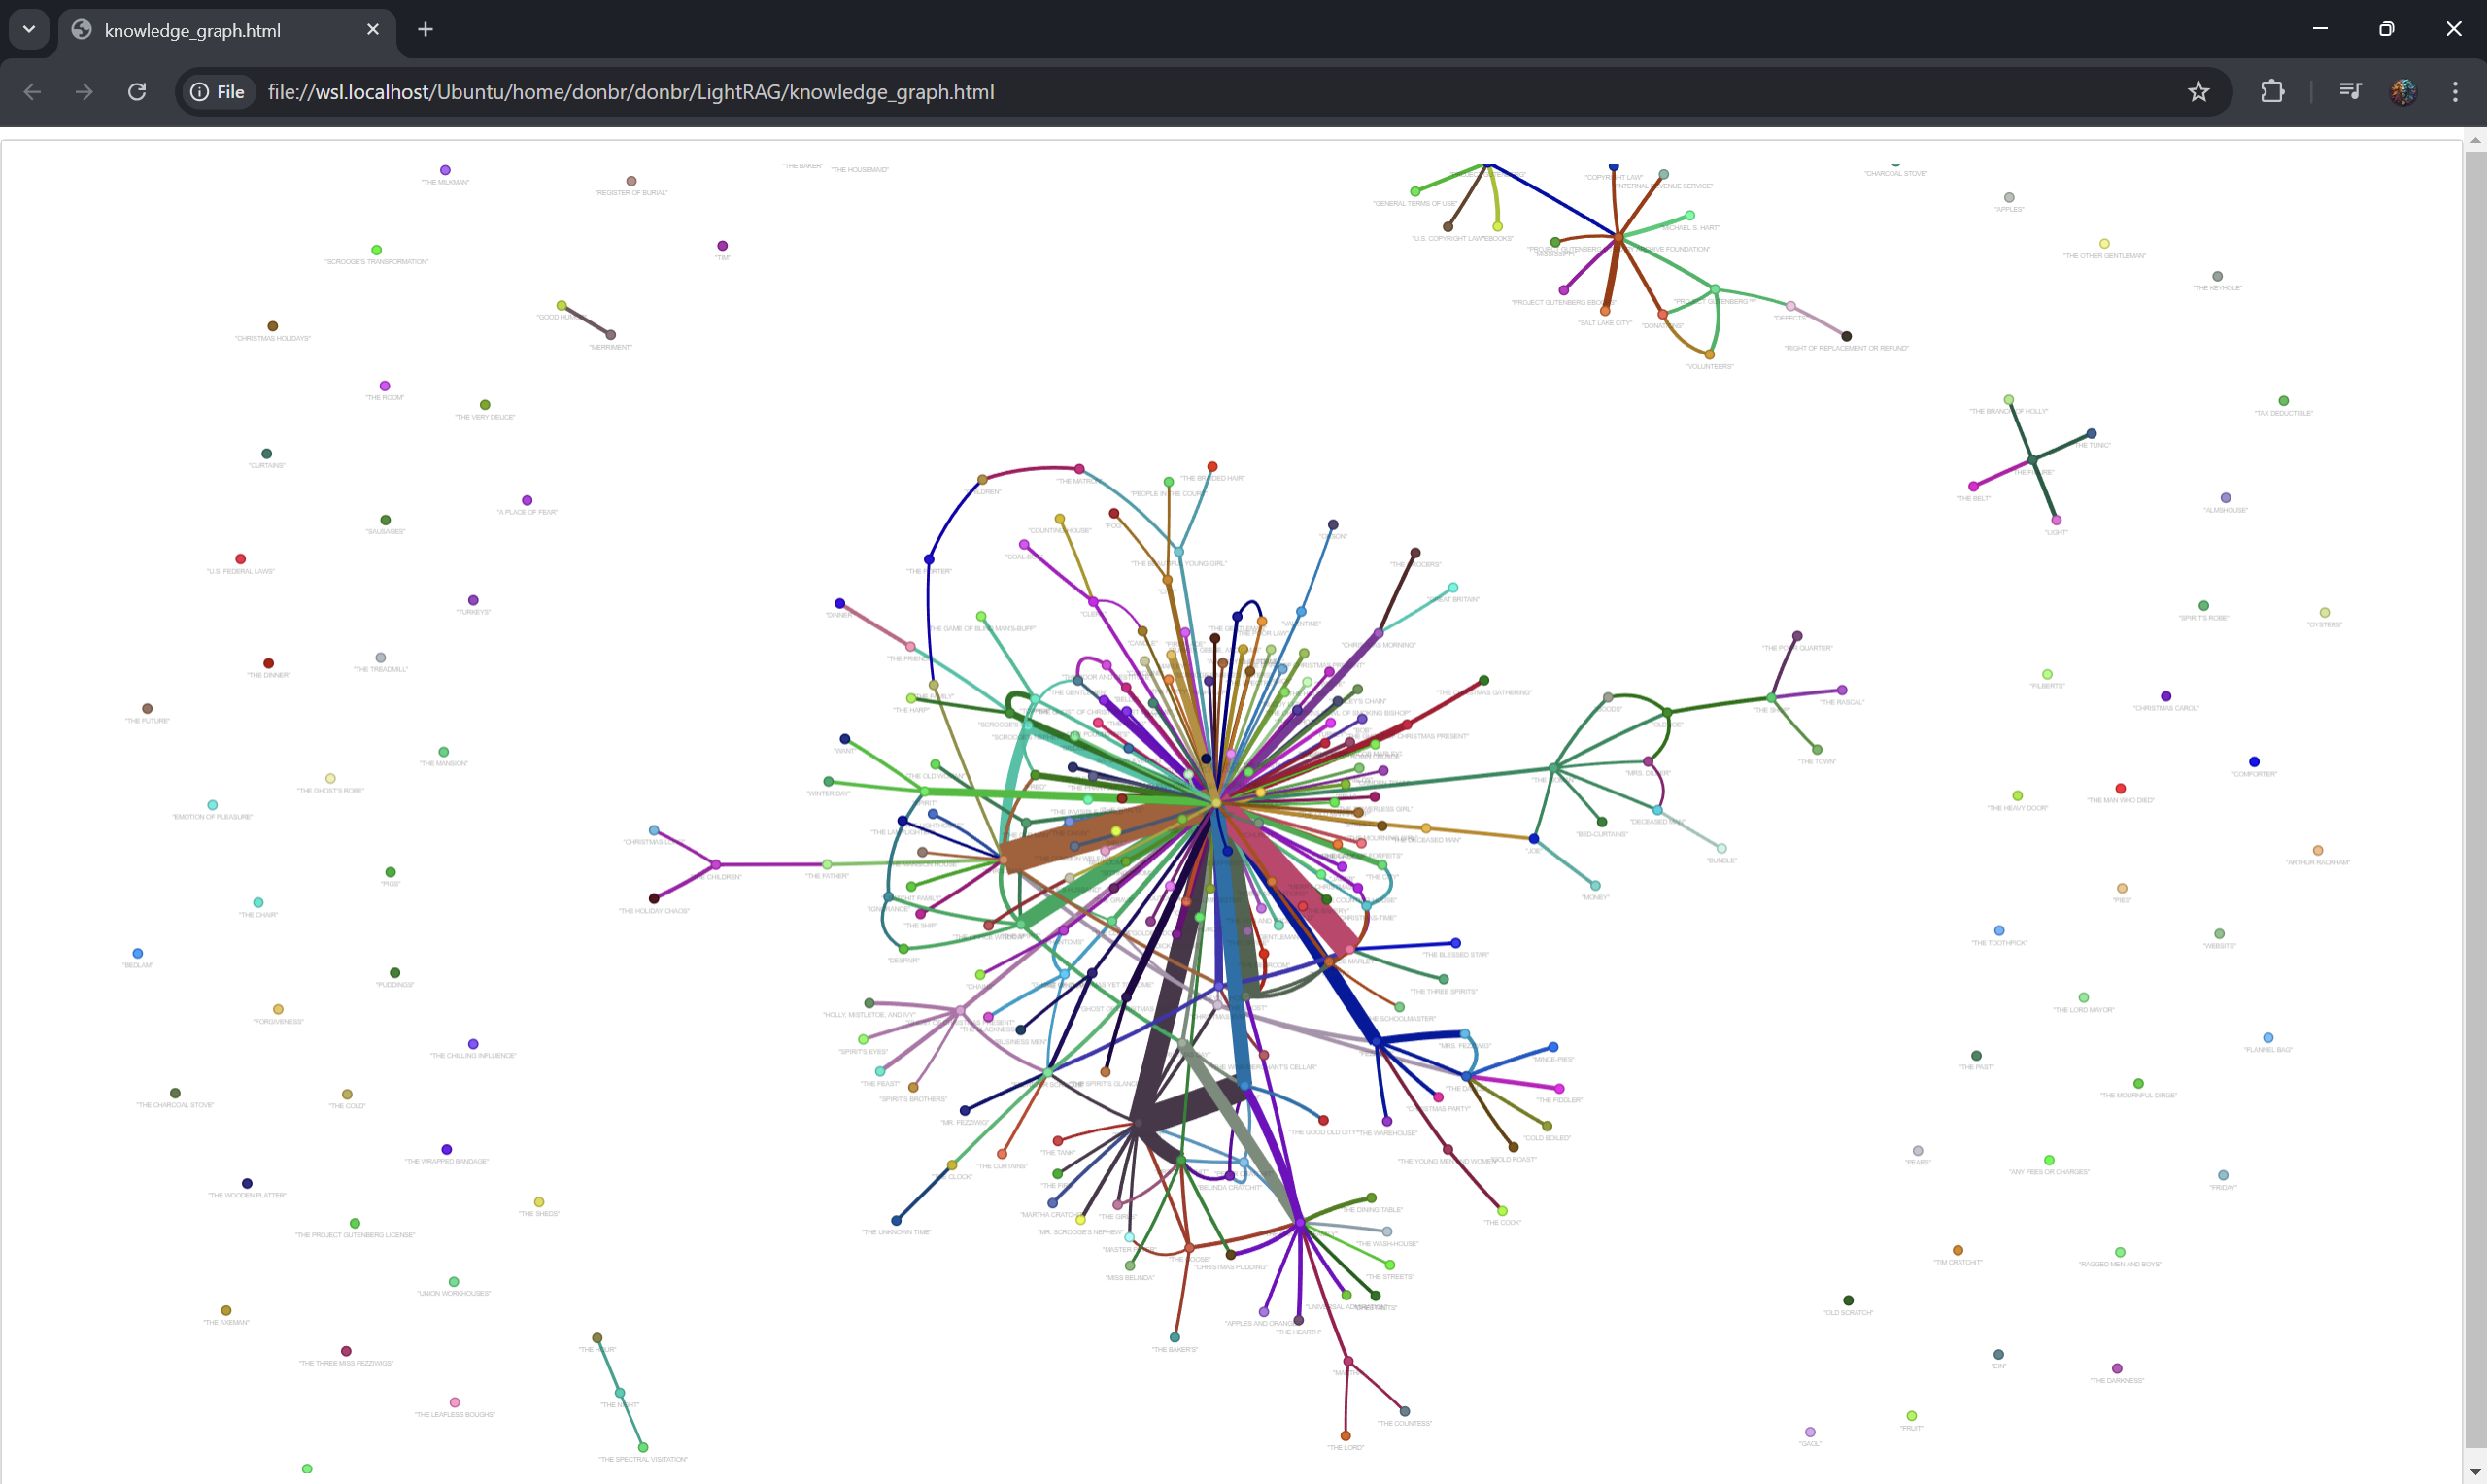

## Review Telemetry data

- Access the Arize Phoenix UI at [http://localhost:6006](http://localhost:6006)

### Arize Phoenix - Card View

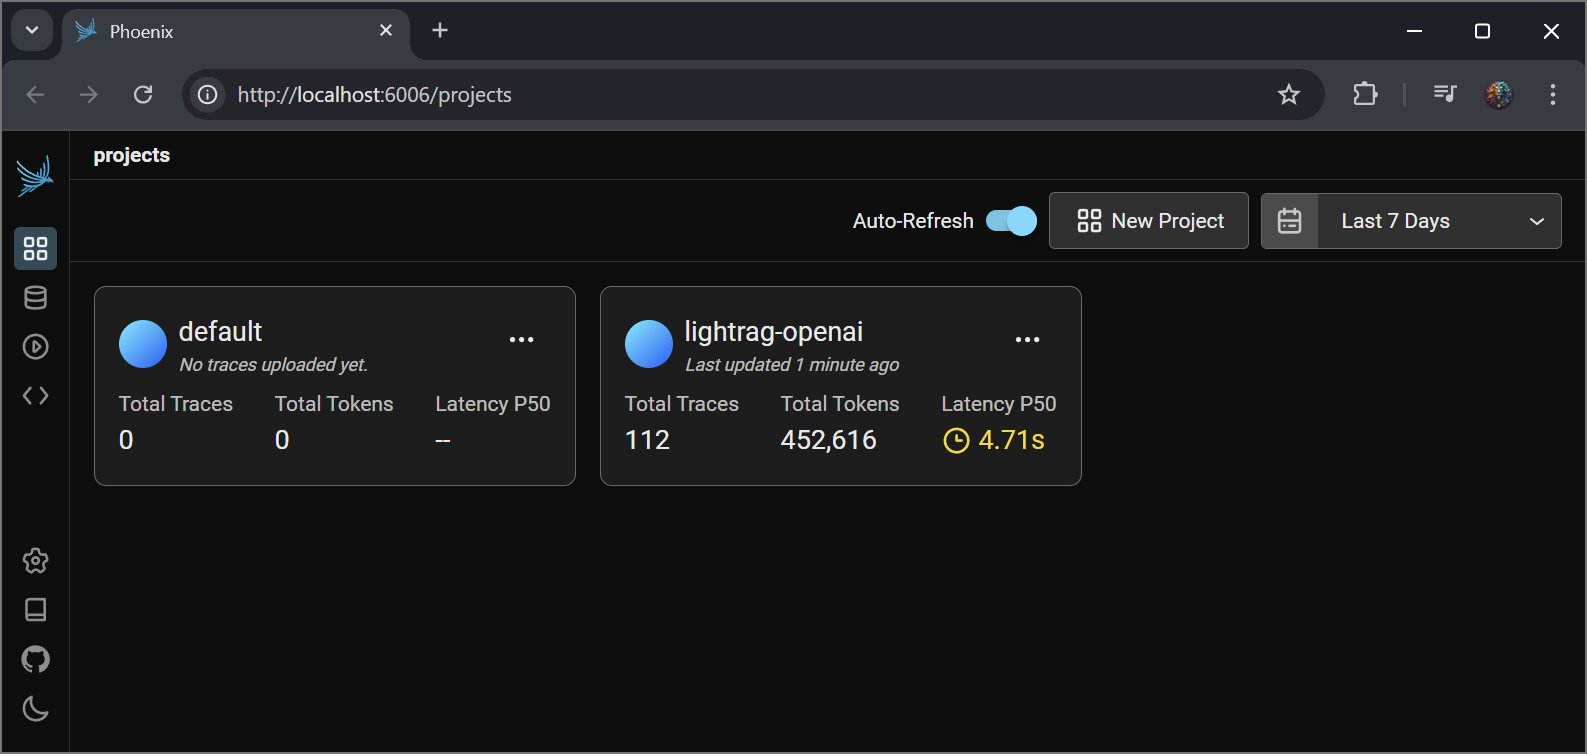

### Arize Phoenix - List View

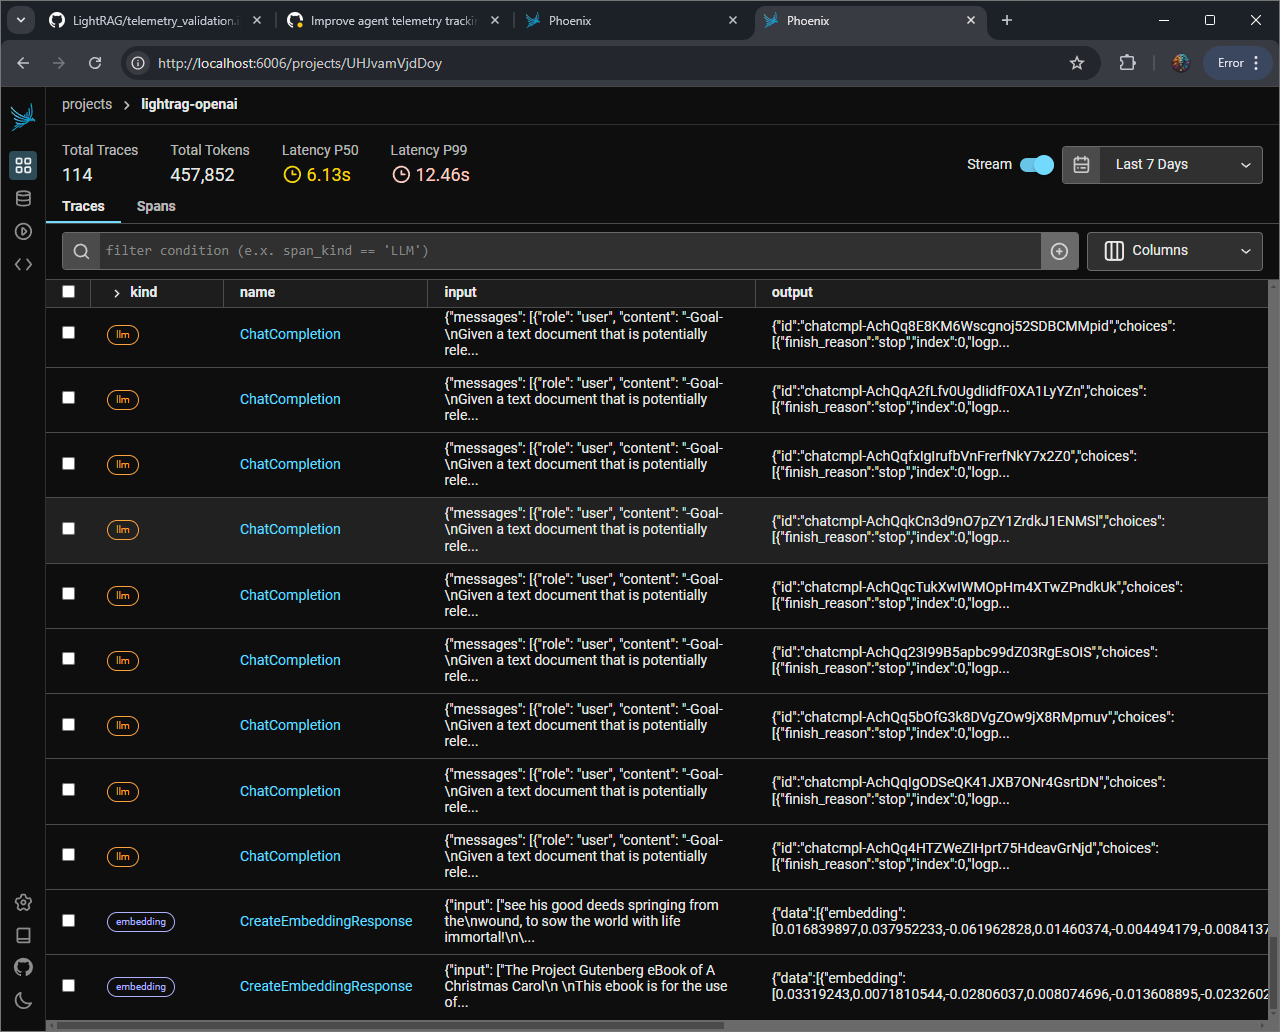

### Arize Phoenix - Detail View - LLM

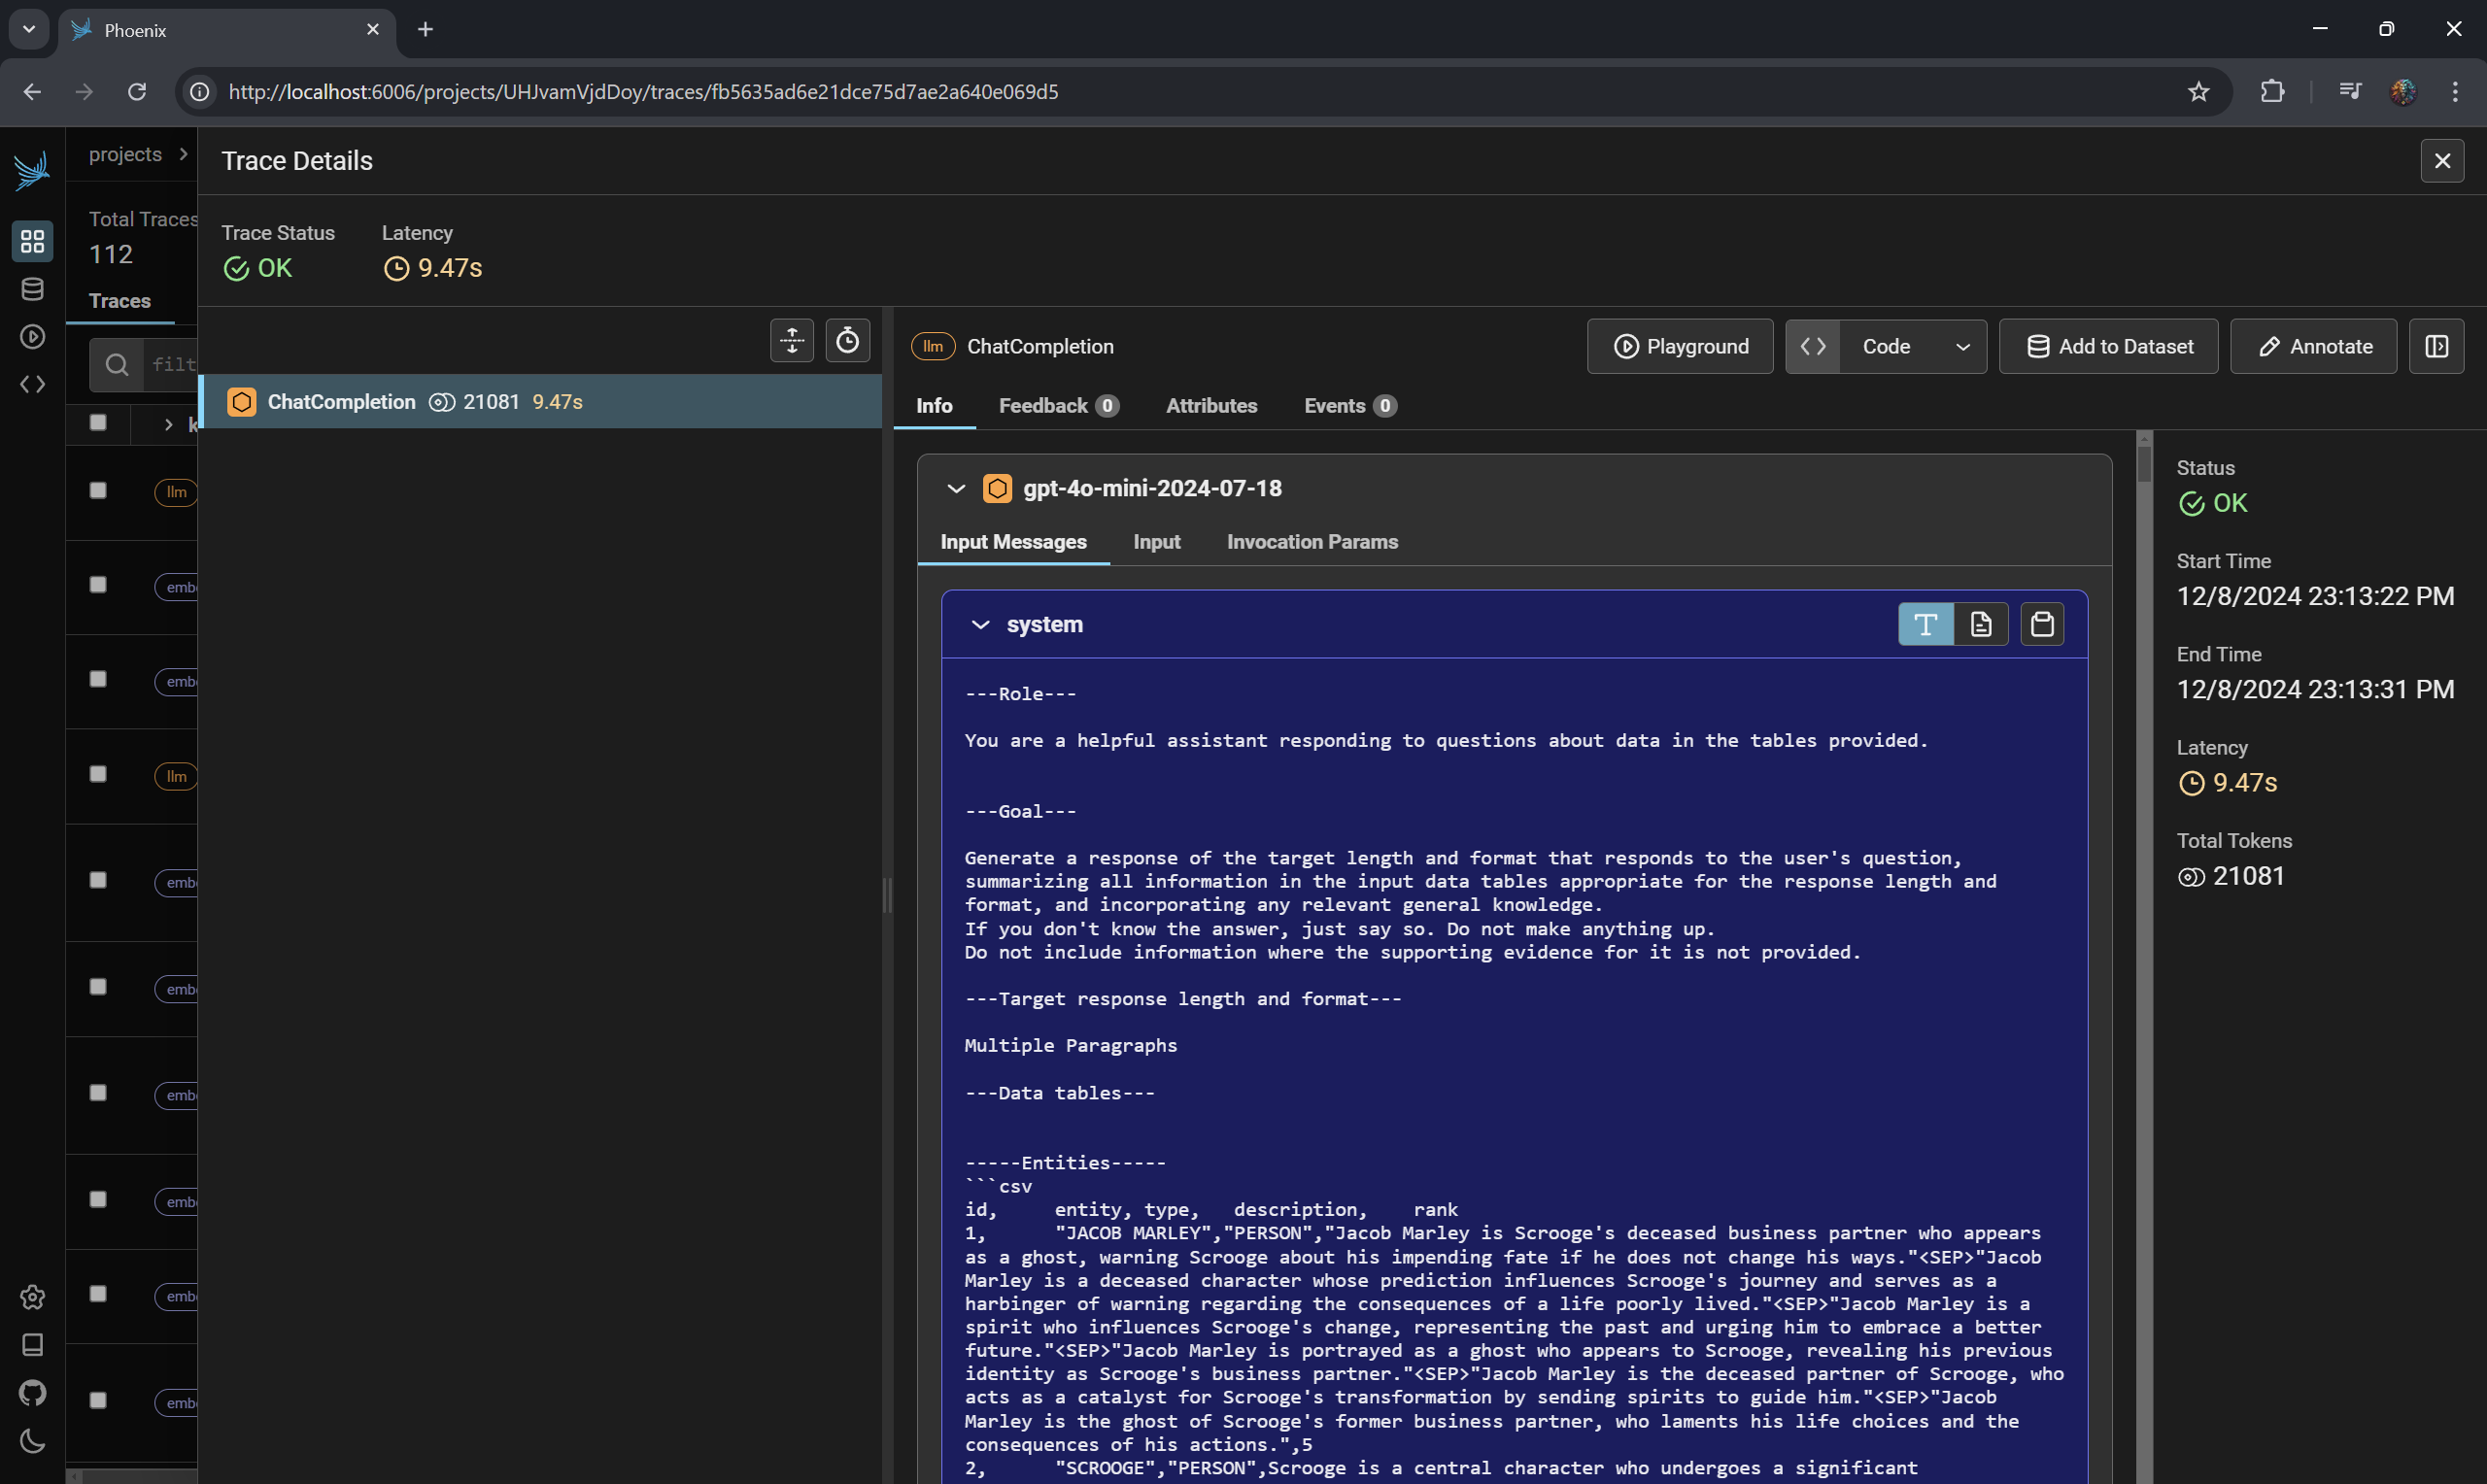

Arize Phoenix - Detail View - Embeddings

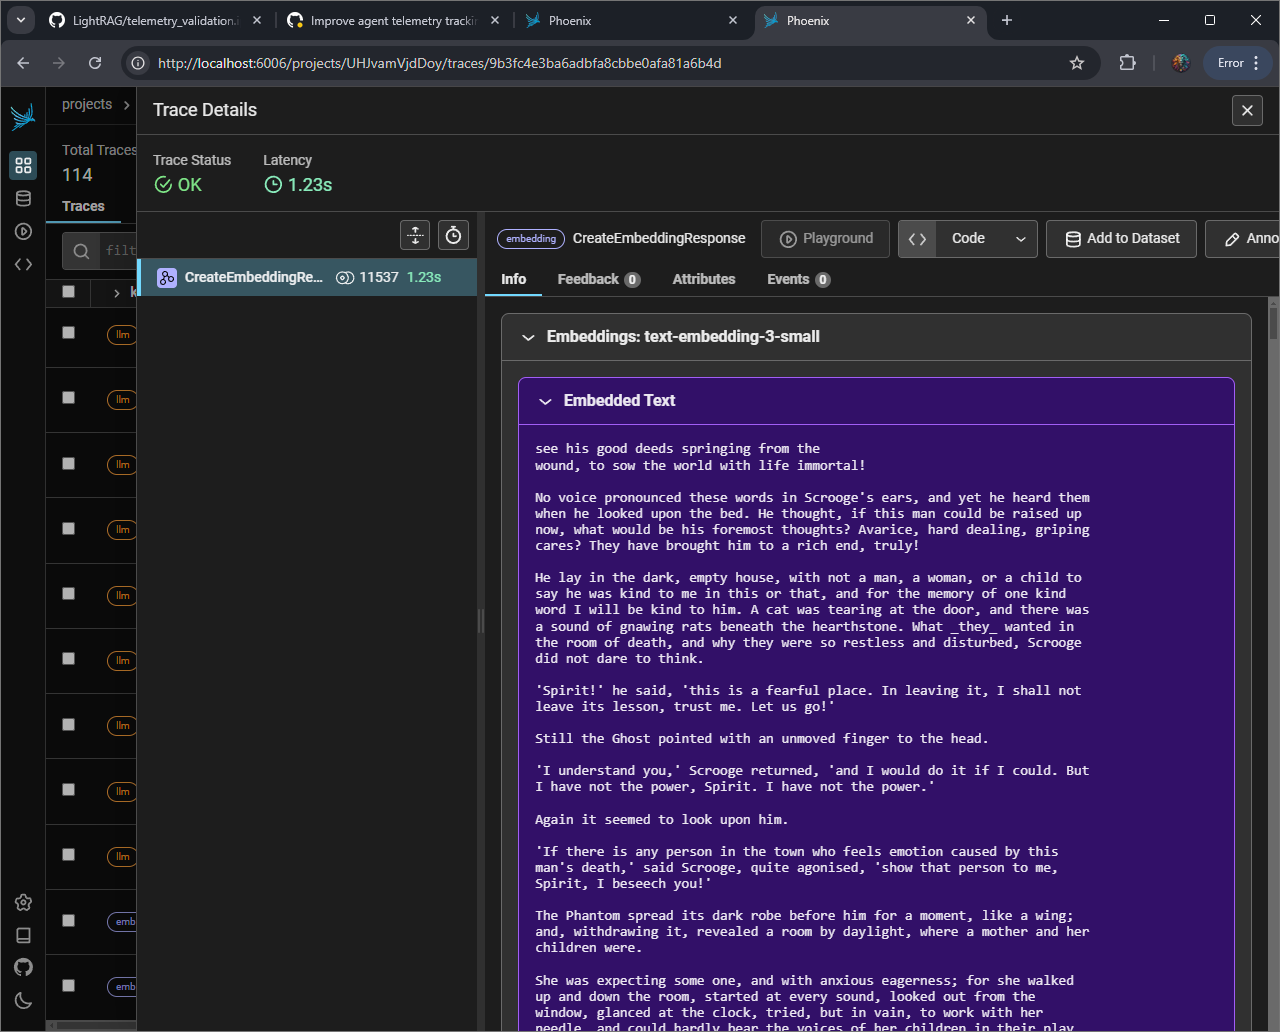